In [3]:
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor


import sys
import os

import sys
import os
sys.path.append(os.path.abspath("../../.."))

from utils.scatter_plot import scatter_prediction
from utils.eval_call import evaluate_model

from Preprocessing.imputation import get_imputation_maps, apply_imputation, ContextImputer

from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model
from sklearn.model_selection import GridSearchCV


Training KNN model ...

Performing Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/anaconda3/envs/data_mining_project/lib/python3.11/site-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/anaconda3/envs/data_mining_project/lib/python3.11/site-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/anaconda3/envs/data_mining_project/lib/python3.11/site-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/anaconda3/envs/data_mining_project/lib/python3.11/site-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/anaconda3/envs/data_mining_project/lib/


Best parameters found:
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 6, 'model__p': 2, 'model__weights': 'distance'}
Best score: 239112811.3311 MSE
KNN Regression Performance Metrics:
MAE: 3983.36
MAPE: 18.50
RMSE: 29829.56
R²: 0.57
------------------------------


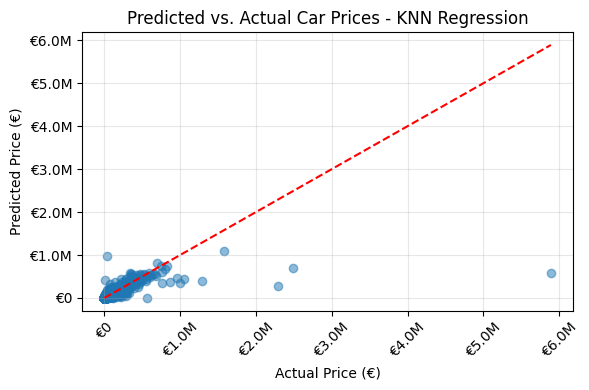

In [4]:
X_train, X_test, y_train, y_test, categorical_features , numeric_features = split_data('../../../data.csv')

    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Scaling is crucial for KNN
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



final_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=4,
        weights='distance',  
        algorithm='auto',
        p = 2, #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
        n_jobs=-1  
    ))
])


print("\nTraining KNN model ...")
final_knn_pipeline.fit(X_train, y_train)

param_grid = {
    'model__n_neighbors': [ 4, 5, 6],
    'model__weights': ['distance'],
    'model__p': [2],  # 1 Manhattan distance, 2 Euclidean
    'model__algorithm': [ 'ball_tree'] #auto due to zu wenig rechen power
}


print("\nPerforming Grid Search...")
grid_search = GridSearchCV(
    estimator=final_knn_pipeline,
    param_grid=param_grid,
    #cv=5,  # 5 fold cross-validation
    n_jobs=1,  # single process avoid serialization issues
    verbose=1,
    scoring='neg_mean_squared_error'
)


grid_search.fit(X_train, y_train)


print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best score: {-grid_search.best_score_:.4f} MSE")


final_knn_pipeline = grid_search.best_estimator_
y_pred_knn = final_knn_pipeline.predict(X_test)


evaluate_model(y_test, y_pred_knn, "KNN Regression")

scatter_prediction(y_test, y_pred_knn, "KNN Regression")